<a href="https://colab.research.google.com/github/jespimentel/orcamento-sp-webservice/blob/main/sigeo_fazenda_sp(MP).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Consulta ao web service da SeFaz-SP e análise da execução orçamentária

1) Este notebook demonstra como consultar as informações de execução financeira e orçamentária disponibilizados em web service da Secretaria da Fazenda e Planejamento do Estado de São Paulo.

2) Uma vez que o web service fornece resposta no formato XML, utilizou-se a biblioteca Beautiful Soup para extrair as informações das tags de interesse.

3) Na sequência, fez-se uso do Pandas para a criação do DataFrame, exploração dos dados e gravação de arquivo Excel.


In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests

In [2]:
# Consultar Despesas

url = "https://webservices.fazenda.sp.gov.br/WSTransparencia/TransparenciaServico.asmx?op=ConsultarDespesas"

headers = {'Content-Type': 'text/xml'}
payload = "<?xml version=\"1.0\" encoding=\"utf-8\"?>\n<soap:Envelope xmlns:xsi=\"http://www.w3.org/2001/XMLSchema-instance\" xmlns:xsd=\"http://www.w3.org/2001/XMLSchema\" xmlns:soap=\"http://schemas.xmlsoap.org/soap/envelope/\">\n<soap:Body>\n<ConsultarDespesas xmlns=\"http://fazenda.sp.gov.br/wstransparencia\">\n<ano>2021</ano>\n<codigoOrgao>27000</codigoOrgao>\n<codigoFonteRecursos>Detalhado</codigoFonteRecursos>\n<flagCredor>1</flagCredor>\n<flagEmpenhado>1</flagEmpenhado>\n<flagLiquidado>1</flagLiquidado>\n<flagPago>1</flagPago>\n</ConsultarDespesas>\n</soap:Body>\n</soap:Envelope>"

response = requests.request("POST", url, headers=headers, data=payload, verify=False)

print("Status code: ", response.status_code)

/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Status code:  200


In [3]:
despesas = response.text
bs_despesas = BeautifulSoup(despesas)

In [4]:
# Criação do DataFrame de Despesas

nome_orgao = bs_despesas.find_all('codigonomeorgao')
fonte = bs_despesas.find_all('codigonomefonterecursos')
tipo_licitacao = bs_despesas.find_all('codigonometipolicitacao')
favorecido = bs_despesas.find_all('cgccpffavorecido')
natureza = bs_despesas.find_all('naturezadespesanomeitem')
empenhado = bs_despesas.find_all('valorempenhado')
liquidado = bs_despesas.find_all('valorliquidado')
pago = bs_despesas.find_all('valorpago')
anos_anteriores = bs_despesas.find_all('valorpagoanosanteriores')

In [5]:
dados_despesas = []
for n in range(0,len(nome_orgao)):
  linhas = [nome_orgao[n].get_text(), fonte[n].get_text(), tipo_licitacao[n].get_text(), favorecido[n].get_text(), 
            natureza[n].get_text(), empenhado[n].get_text(), liquidado[n].get_text(), pago[n].get_text(), 
            anos_anteriores[n].get_text()]
  dados_despesas.append(linhas)

In [6]:
df_despesas = pd.DataFrame(dados_despesas, columns=['Órgão', 'Fonte de recursos', 'Tipo de licitação', 'Favorecido', 
                                                    'Natureza','Empenhado', 'Liquidado', 'Pago', 'Anos anteriores'])

#Eliminação da linha de totalização
df_despesas['Órgão'].replace('', np.nan, inplace=True)
df_despesas.dropna(subset = ['Órgão'], inplace=True) 

df_despesas.head()

,Órgão,Fonte de recursos,Tipo de licitação,Favorecido,Natureza,Empenhado,Liquidado,Pago,Anos anteriores
0,27000 - MINISTERIO PUBLICO,001 - TESOURO-DOT.INICIAL E CRED.SUPLEMENTAR,0 - ADIANTAMENTO,14849889816 - JULIO CESAR IZIDORIO,33903024 - OUTROS COMBUSTIVEIS E LUBRIFICANTES,"4.531,39","4.531,39","4.531,39","0,00"
1,27000 - MINISTERIO PUBLICO,001 - TESOURO-DOT.INICIAL E CRED.SUPLEMENTAR,0 - ADIANTAMENTO,09978904875 - SERGIO CELESTINO,33903050 - PECAS DE REPOSICAO E ACESSORIOS,"2.202,00","2.202,00","2.202,00","0,00"
2,27000 - MINISTERIO PUBLICO,001 - TESOURO-DOT.INICIAL E CRED.SUPLEMENTAR,0 - ADIANTAMENTO,12950740871 - MARCELO ALENCAR CERQUEIRA,33903050 - PECAS DE REPOSICAO E ACESSORIOS,"1.947,53","1.947,53","1.947,53","0,00"
3,27000 - MINISTERIO PUBLICO,001 - TESOURO-DOT.INICIAL E CRED.SUPLEMENTAR,0 - ADIANTAMENTO,09765043830 - LUIZ ANTONIO NUNES FILHO,33903052 - MATERIAL P/ CONSERVACAO E MANUT. DE...,"18.773,35","18.773,35","18.773,35","0,00"
4,27000 - MINISTERIO PUBLICO,001 - TESOURO-DOT.INICIAL E CRED.SUPLEMENTAR,0 - ADIANTAMENTO,14763824848 - ROSEMEIRE DANIEL,33903061 - PECAS E ACESSOR.E COMPONENTES DE IN...,"3.000,00","3.000,00","3.000,00","0,00"


In [7]:
def converte (str_numero):
    try:
        str_numero = str_numero.replace('.', '').replace(',','.')
        return float(str_numero)
    except:
        return str_numero

df_despesas['Empenhado'] = df_despesas['Empenhado'].apply(lambda x:converte(x))
df_despesas['Liquidado'] = df_despesas['Liquidado'].apply(lambda x:converte(x))
df_despesas['Pago'] = df_despesas['Pago'].apply(lambda x:converte(x))
df_despesas['Anos anteriores'] = df_despesas['Anos anteriores'].apply(lambda x:converte(x))
df_despesas.head()

,Órgão,Fonte de recursos,Tipo de licitação,Favorecido,Natureza,Empenhado,Liquidado,Pago,Anos anteriores
0,27000 - MINISTERIO PUBLICO,001 - TESOURO-DOT.INICIAL E CRED.SUPLEMENTAR,0 - ADIANTAMENTO,14849889816 - JULIO CESAR IZIDORIO,33903024 - OUTROS COMBUSTIVEIS E LUBRIFICANTES,4531.39,4531.39,4531.39,0.0
1,27000 - MINISTERIO PUBLICO,001 - TESOURO-DOT.INICIAL E CRED.SUPLEMENTAR,0 - ADIANTAMENTO,09978904875 - SERGIO CELESTINO,33903050 - PECAS DE REPOSICAO E ACESSORIOS,2202.00,2202.00,2202.00,0.0
2,27000 - MINISTERIO PUBLICO,001 - TESOURO-DOT.INICIAL E CRED.SUPLEMENTAR,0 - ADIANTAMENTO,12950740871 - MARCELO ALENCAR CERQUEIRA,33903050 - PECAS DE REPOSICAO E ACESSORIOS,1947.53,1947.53,1947.53,0.0
3,27000 - MINISTERIO PUBLICO,001 - TESOURO-DOT.INICIAL E CRED.SUPLEMENTAR,0 - ADIANTAMENTO,09765043830 - LUIZ ANTONIO NUNES FILHO,33903052 - MATERIAL P/ CONSERVACAO E MANUT. DE...,18773.35,18773.35,18773.35,0.0
4,27000 - MINISTERIO PUBLICO,001 - TESOURO-DOT.INICIAL E CRED.SUPLEMENTAR,0 - ADIANTAMENTO,14763824848 - ROSEMEIRE DANIEL,33903061 - PECAS E ACESSOR.E COMPONENTES DE IN...,3000.00,3000.00,3000.00,0.0


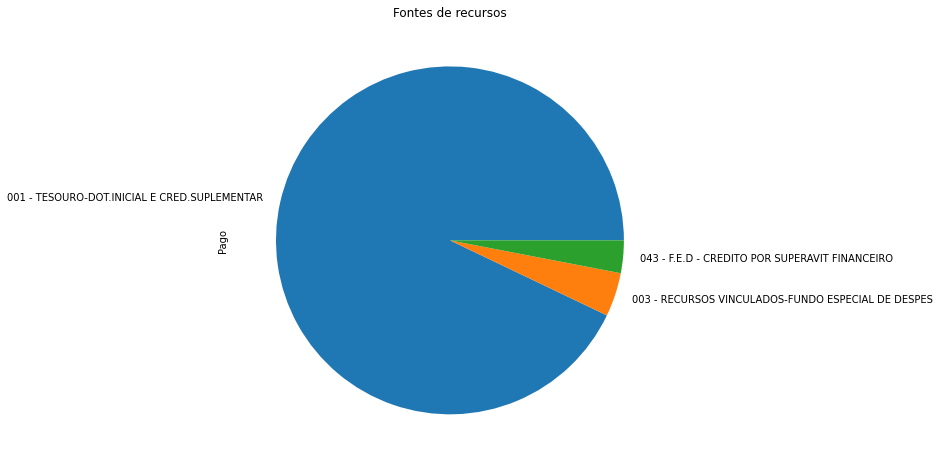

In [8]:
fontes = df_despesas.groupby('Fonte de recursos')['Pago'].sum()
fontes.plot.pie(title = 'Fontes de recursos', figsize=(10,8))

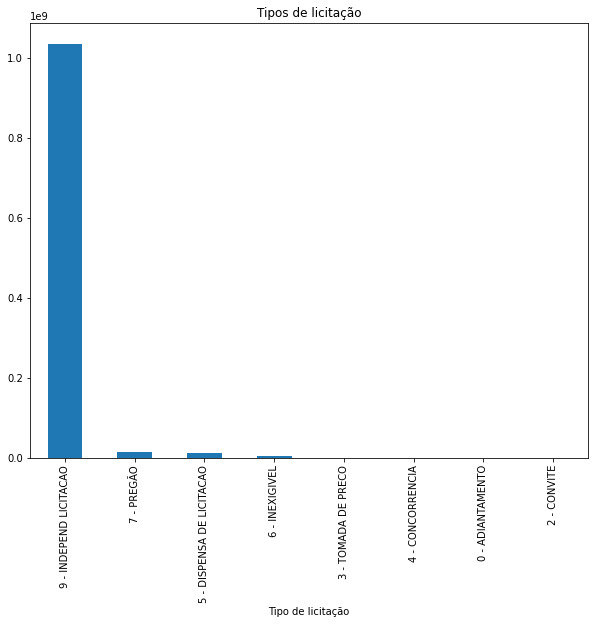

In [9]:
tipos_licitacao = df_despesas.groupby('Tipo de licitação')['Pago'].sum()
tipos_licitacao.sort_values(ascending=False).head(20).plot.bar(title = 'Tipos de licitação', figsize=(10,8))

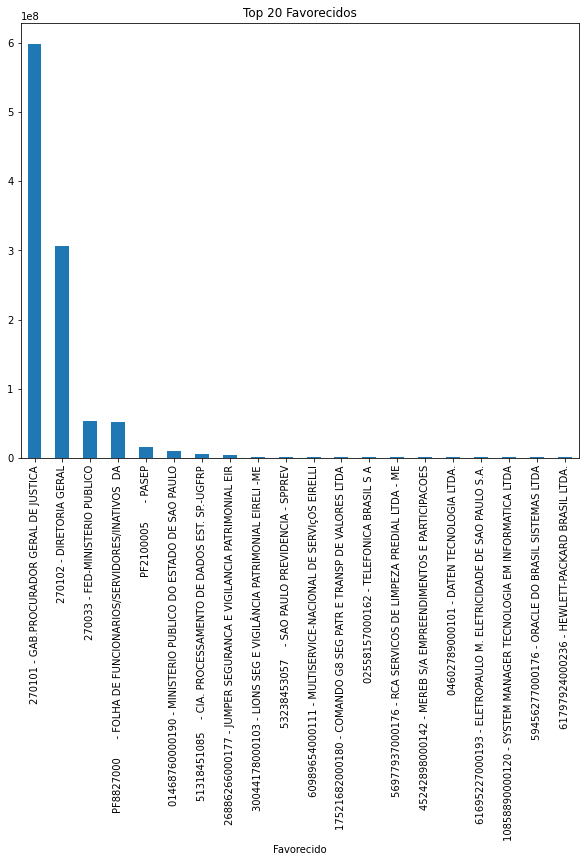

In [10]:
favorecido = df_despesas.groupby('Favorecido')['Pago'].sum()
favorecido.sort_values(ascending=False).head(20).plot.bar(title = 'Top 20 Favorecidos', figsize=(10,8))

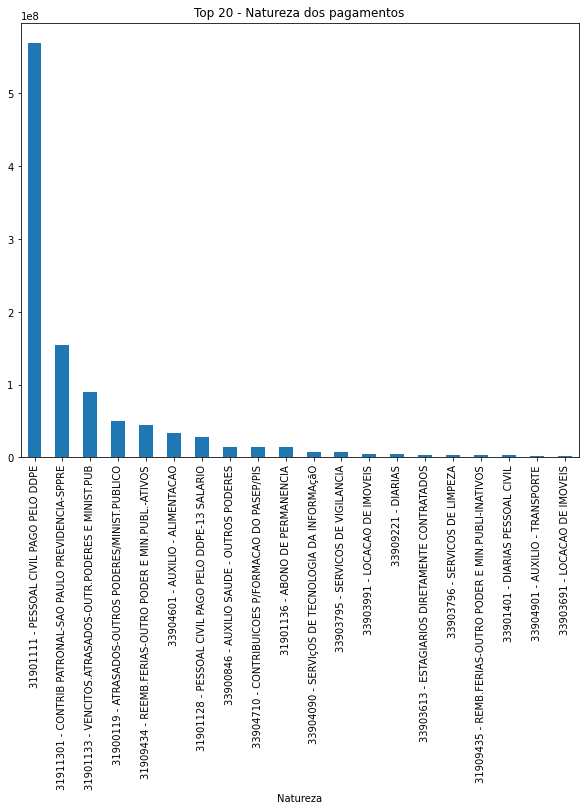

In [11]:
natureza = df_despesas.groupby('Natureza')['Pago'].sum()
natureza.sort_values(ascending=False).head(20).plot.bar(title = 'Top 20 - Natureza dos pagamentos', figsize=(10,8))

In [12]:
df_despesas.to_excel('despesas.xlsx')

Consulta web:https://www.fazenda.sp.gov.br/SigeoLei131/Paginas/FlexConsDespesa.aspx

Link de acesso ao webservice da Fazenda: https://webservices.fazenda.sp.gov.br/WSTransparencia/TransparenciaServico.asmx

Manual técnico: https://portal.fazenda.sp.gov.br/acessoinformacao/Downloads/Webservice/Manual%20do%20Webservice.pdf

Conversão do XML em Dataframe baseado em: https://www.geeksforgeeks.org/convert-xml-structure-to-dataframe-using-beautifulsoup-python/

Criado em 11 jul. 2021.